# Make a Flamingo Euclid RR2 catalog/map

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import LSS_forward_model
from LSS_forward_model.cosmology import *
from LSS_forward_model.lensing import *
from LSS_forward_model.maps import *
from LSS_forward_model.halos import *
from LSS_forward_model.tsz import *
import os
import pandas as pd
import numpy as np
import healpy as hp
from cosmology import Cosmology
import astropy.io.fits as fits
import copy
import glass
import frogress
from astropy.cosmology import wCDM

In [77]:
path_data_cats = '/global/cfs/cdirs/m5099/RR2/Euclid_cats.npy'

# nuisance parameters for the mocks
SC_corrections = np.load('../Data/SC_RR2_fit.npy',allow_pickle =True).item() # RR2 source clustering corrections

# it's a non tomographic bin + 6 tomographic bins.
nuisance_parameters = dict()
nuisance_parameters['dz'] =  [0,0,0,0,0,0,0]
nuisance_parameters['dm'] = [1,1,1,1,1,1,1]
nuisance_parameters['A_IA'] = 0.
nuisance_parameters['eta_IA'] = 0.
nuisance_parameters['bias_sc'] = [1,1,1,1,1,1,1]
nuisance_parameters['rot'] = 0

# Flamingo Cosmology ****************************************
sims_parameters = {'Omega_b': 0.0486	,
 'Omega_nu': 1.39 * 0.001,
 'Omega_m': 0.306	,
 'Omega_cdm': 0.25601,
 'h':  0.681,
 'w0': -1.0,
 'wa': 0.0,
 'As': 2.099e-09,
 'n_s': 0.967,
 'sigma_8': 0.807,
 'm_nu': 0.060,
 'dBoxSize Mpc/h': 1000}

# append nuisance parameters
for key in nuisance_parameters.keys():
    sims_parameters[key] = nuisance_parameters[key]
    
# Set-up cosmology objects for the pipeline: cosmo_pyccl, camb_pars
camb_pars = camb.set_params(H0=100*sims_pameters['h'], omch2=sims_pameters['Omega_cdm']*sims_pameters['h']**2, ombh2=sims_pameters['Omega_b']*sims_pameters['h']**2, w=sims_pameters['w0'],
                               NonLinear=camb.model.NonLinear_both)

cosmo_pyccl = ccl.Cosmology(Omega_c = sims_pameters['Omega_cdm'], Omega_b = sims_pameters['Omega_b'], h =  0.681, sigma8 = sims_pameters['sigma_8'], n_s = sims_pameters['n_s'], w0 = sims_pameters['w0'],m_nu = [sims_pameters['m_nu']/3,sims_pameters['m_nu']/3,sims_pameters['m_nu']/3],mass_split='equal',
                                  matter_power_spectrum='linear')




cosmology = wCDM(H0= 100*sims_pameters['h'],
         Om0=sims_pameters['Omega_m'],
         Ode0=1-sims_pameters['Omega_m'],
         w0=sims_pameters['w0'])

            
z_edges = np.linspace(0,3.0,61)
# I don't have access to these files! ------
#z_edges = np.hstack([z_edges,np.linspace(3.0,5.0,9)])
#z_edges = np.hstack([z_edges,5.50])
#z_edges = np.hstack([z_edges,6.04])
comoving_edges =  cosmology.comoving_distance(z_edges).value

# steps goes from 0 to N, and z from far to close.
shells_info = dict()
shells_info['Step'] = np.arange(len(z_edges)-1)
shells_info['z_far'] = z_edges[::-1][:-1]
shells_info['z_near'] =  z_edges[::-1][1:]
shells_info['delta_z'] = -shells_info['z_far']+shells_info['z_near']
shells_info['cmd_far'] = comoving_edges[::-1][:-1]
shells_info['cmd_near'] = comoving_edges[::-1][1:]
shells_info['delta_cmd'] = -shells_info['cmd_far'] + shells_info['cmd_near'] 
shells_info['z_edges'] = z_edges[::-1]
shells_info['mean_z'] = 0.5*(z_edges[::-1][1:]+z_edges[::-1][:-1])


# setup n(z)

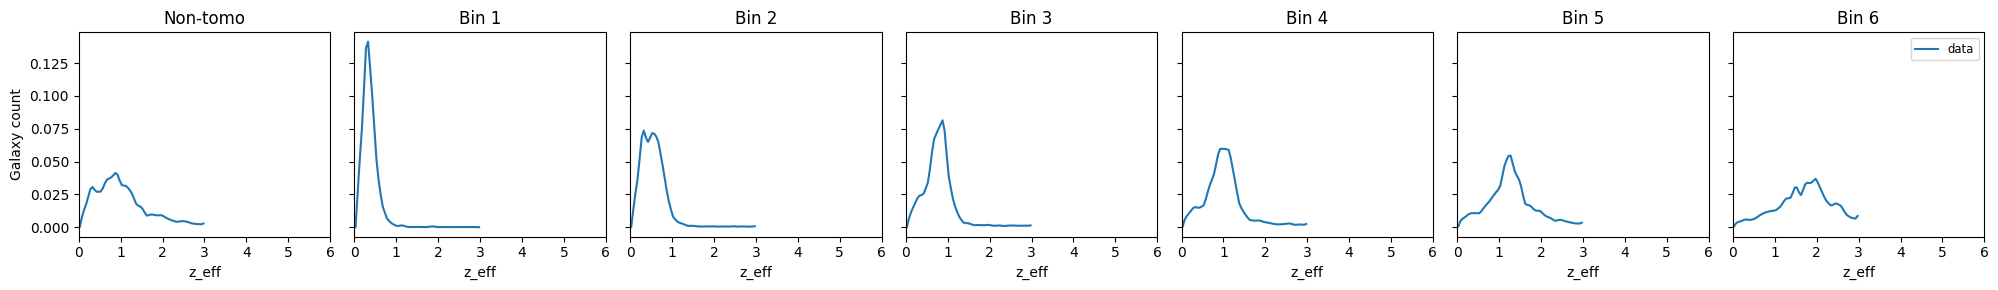

In [78]:
# Setup n(z) ********************************
nz_file = fits.open('/global/cfs/cdirs/m5099/RR2/Reg2_SHE_tombins_unitweights_nz_SOMbin_C2020z.fits')
# sims: = np.loadtxt('/pscratch/sd/m/mgatti/euclid/mean_sampled_nzs_6bins/density_False/equi_pop/nz_LCDM_nofz_FS2_area25deg2_DR1_opt_equi_pop_0{0}.cat'.format(i))
    
nz = []
redshift = np.linspace(0,6,3001)
n_bins = 50
bin_factor = len(nz_file[1].data['N_Z'][0]) // n_bins 
n_trim = bin_factor * n_bins 
z_rebinned = redshift[:n_trim].reshape(n_bins, bin_factor).mean(axis=1)

############################################
nz_ = [nz_file[1].data['N_Z'][0]+nz_file[1].data['N_Z'][1]+nz_file[1].data['N_Z'][2]+nz_file[1].data['N_Z'][3]+nz_file[1].data['N_Z'][4]+nz_file[1].data['N_Z'][5]]
for i in range(6):
    nz_.append(nz_file[1].data['N_Z'][i])

for ix in range(len(nuisance_parameters['dz'])):
    nz_rebinned = nz_[ix][:n_trim].reshape(n_bins, bin_factor).sum(axis=1)

    # apply a shift in the mean ------
    nz_shifted_on_rebinned = shift_nz(
                z=z_rebinned,
                nz=nz_rebinned,
                z_rebinned=z_rebinned,
                delta_z=sims_parameters['dz'][ix],
                renorm="source"  # keep the original integral
            )

    
    norm = np.trapz(nz_shifted_on_rebinned,z_rebinned)
    nz.append(nz_shifted_on_rebinned/norm)
nz = np.array(nz)
redshift = copy.deepcopy(z_rebinned)

shells, steps, zeff, ngal_glass = build_shell_windows_and_partitions(
    shells_info=shells_info,
    redshift=redshift,
    nz=nz,
    samples_per_shell=100,
)


# Plot -----------------------------------------------------------------
fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for i, ax in enumerate(axes):
    ax.plot(zeff, ngal_glass[i], label="data")
    ax.set_xlim(0, 6)
    ax.set_title(titles[i])
    if i == 0: ax.set_ylabel("Galaxy count")
    ax.set_xlabel("z_eff")
axes[-1].legend(loc="upper right", fontsize="small")
plt.tight_layout(); plt.show()

# load density shells and compute shear field

In [48]:
type_  = 'HYDRO_FIDUCIAL'
path = "/pscratch/sd/j/junzhez/flamingo/flamingo_reduced_tsz/{0}/lightcone0_shells_nside1024/".format(type_)

# load density -------------------------
# Assuming you start from redshift 0 and you go higher z
density = []
for i in range(len(z_edges)-1):
    m = h5.File(path+'shell_{0}.hdf5'.format(i))
    mass = np.array(m['TotalMass'])
    d = mass/np.mean(mass)-1.
    density.append(d)
density = np.array(density)


# shear field ---------------------------
cosmo = Cosmology.from_camb(camb_pars)
gamma_ = []

convergence = glass.lensing.MultiPlaneConvergence(cosmo)
for ss in frogress.bar(range(len(density))):
   
    convergence.add_window(density[ss], shells[ss])
    # get convergence field
    kappa = copy.deepcopy(convergence.kappa)
    gamma = glass.lensing.from_convergence(kappa, lmax=nside_maps*3-1, shear=True)
    gamma_.append(gamma)
         
gamma_ = np.array(gamma_)


# IA field ---------------------------
cosmo = Cosmology.from_camb(camb_pars)
IA_shear_ = []

convergence = glass.lensing.MultiPlaneConvergence(cosmo)
for ss in frogress.bar(range(len(density))):
    # get convergence field
    IA_shear = glass.lensing.from_convergence(density[ss]-np.mean(density[ss]), lmax=nside_maps*3-1, shear=True)
    IA_shear_.append(IA_shear)

IA_shear_ = np.array(IA_shear_)


100.0% | [##########] | Progress: 60 / 60 | Time: 49.2s | ETA: --              

# Make mocks/maps

In [ ]:
corr_variance_array =  [  SC_corrections['corr_variance_fit'][tomo](sims_parameters['bias_sc'][tomo])       for tomo in range(nz.shape[0])]
coeff_kurtosis_array = [  SC_corrections['coeff_kurtosis_fit'][tomo](sims_parameters['bias_sc'][tomo])       for tomo in range(nz.shape[0])]
A_corr_array = [  SC_corrections['A_corr_fit'][tomo](sims_parameters['bias_sc'][tomo])       for tomo in range(nz.shape[0])]


# kappa_tot  = np.zeros((nz.shape[0],12*nside_maps**2))
g1_tot  = np.zeros((nz.shape[0],12*nside_maps**2))
g2_tot  = np.zeros((nz.shape[0],12*nside_maps**2))
d_tot  = np.zeros((nz.shape[0], 12*nside_maps**2))


# load each lightcone output in turn and add it to the simulation
# note: I added a -sign to gamma to match data conventions later
for tomo in range(nz.shape[0]):
    for i in (range(len(gamma_))):       
        C1 = 5e-14
        rho_crit0_h2 = ccl.physical_constants.RHO_CRITICAL
        rho_c1 = C1 * rho_crit0_h2
        IA_f = F_nla(z=zeff[i],
         om0=sims_parameters['Omega_m'],
         A_ia=nuisance_parameters['A_IA'], rho_c1=rho_c1, eta=nuisance_parameters['eta_IA'], z0=0.67,
         cosmo=cosmo_pyccl)
        
       # kappa_tot[tomo] += ngal_glass[tomo,i] * kappa_[i][0].real * (1 + bias_sc[tomo] * density[i])
        g1_tot[tomo] += ngal_glass[tomo,i] * (-gamma_[i][0].real-IA_shear_[i][0].real*IA_f) * (1 + sims_parameters['bias_sc'][tomo] * density[i])
        g2_tot[tomo] += ngal_glass[tomo,i] * (-gamma_[i][0].imag-IA_shear_[i][0].imag*IA_f) * (1 + sims_parameters['bias_sc'][tomo] * density[i])
        d_tot[tomo]  += ngal_glass[tomo,i] * (1 + sims_parameters['bias_sc'][tomo] * density[i] )
   


cats_Euclid  = np.load(path_data_cats,allow_pickle=True).item()



In [62]:

maps_Flamingo = dict()
for tomo in range(nz.shape[0]):
    maps_Flamingo[tomo] = dict()

    pix_ = convert_to_pix_coord(cats_Euclid[tomo]['ra'],cats_Euclid[tomo]['dec'], nside=nside_maps*2)
    pix = rotate_and_rebin(pix_, nside_maps, sims_parameters['rot'], delta_=0.)
    sims_parameters['delta_rot'] = 0.
    # ---------------------------------------------------
    
    # source clustering term ~
    f = 1./np.sqrt(d_tot[tomo])
    f = f[pix]


    n_map = np.zeros(hp.nside2npix(nside_maps))
    n_map_sc = np.zeros(hp.nside2npix(nside_maps))

                    
    unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)


    n_map_sc[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[tomo]['w']/f**2)
    n_map[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[tomo]['w'])

    g1_ = g1_tot[tomo][pix]
    g2_ = g2_tot[tomo][pix]


    es1,es2 = apply_random_rotation(cats_Euclid[tomo]['e1']/f, cats_Euclid[tomo]['e2']/f)
    es1_ref,es2_ref = apply_random_rotation(cats_Euclid[tomo]['e1'], cats_Euclid[tomo]['e2'])
    es1a,es2a = apply_random_rotation(cats_Euclid[tomo]['e1']/f, cats_Euclid[tomo]['e2']/f)


    #x1_sc,x2_sc = addSourceEllipticity({'shear1':g1_,'shear2':g2_},{'e1':es1,'e2':es2},es_colnames=("e1","e2"))


    e1r_map = np.zeros(hp.nside2npix (nside_maps))
    e2r_map = np.zeros(hp.nside2npix (nside_maps))
    e1r_map0 = np.zeros(hp.nside2npix(nside_maps))
    e2r_map0 = np.zeros(hp.nside2npix(nside_maps))
    e1r_map0_ref = np.zeros(hp.nside2npix(nside_maps))
    e2r_map0_ref = np.zeros(hp.nside2npix(nside_maps))
    g1_map = np.zeros(hp.nside2npix(nside_maps))
    g2_map = np.zeros(hp.nside2npix(nside_maps))

    unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)


    e1r_map[unique_pix] += np.bincount(idx_rep, weights=es1*cats_Euclid[tomo]['w'])
    e2r_map[unique_pix] += np.bincount(idx_rep, weights=es2*cats_Euclid[tomo]['w'])

    e1r_map0[unique_pix] += np.bincount(idx_rep, weights=es1a*cats_Euclid[tomo]['w'])
    e2r_map0[unique_pix] += np.bincount(idx_rep, weights=es2a*cats_Euclid[tomo]['w'])

    e1r_map0_ref[unique_pix] += np.bincount(idx_rep, weights=es1_ref*cats_Euclid[tomo]['w'])
    e2r_map0_ref[unique_pix] += np.bincount(idx_rep, weights=es2_ref*cats_Euclid[tomo]['w'])


    mask_sims = n_map_sc != 0.
    e1r_map[mask_sims]  = e1r_map[mask_sims]/(n_map_sc[mask_sims])
    e2r_map[mask_sims] =  e2r_map[mask_sims]/(n_map_sc[mask_sims])
    e1r_map0[mask_sims]  = e1r_map0[mask_sims]/(n_map_sc[mask_sims])
    e2r_map0[mask_sims] =  e2r_map0[mask_sims]/(n_map_sc[mask_sims])
    e1r_map0_ref[mask_sims]  = e1r_map0_ref[mask_sims]/(n_map[mask_sims])
    e2r_map0_ref[mask_sims] =  e2r_map0_ref[mask_sims]/(n_map[mask_sims])



    var_ =  e1r_map0_ref**2+e2r_map0_ref**2


    #'''
    e1r_map   *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
    e2r_map   *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
    e1r_map0  *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
    e2r_map0  *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))



    
    
    #'''
    g1_map[unique_pix] += np.bincount(idx_rep, weights= g1_*cats_Euclid[tomo]['w'])
    g2_map[unique_pix] += np.bincount(idx_rep, weights= g2_*cats_Euclid[tomo]['w'])



    g1_map[mask_sims]  = g1_map[mask_sims]/(n_map_sc[mask_sims])
    g2_map[mask_sims] =  g2_map[mask_sims]/(n_map_sc[mask_sims])

    e1_ = ((g1_map*nuisance_parameters['dm'][tomo]+e1r_map0))[mask_sims]
    e2_ = ((g2_map*nuisance_parameters['dm'][tomo]+e2r_map0))[mask_sims]
    e1n_ = ( e1r_map)[mask_sims]
    e2n_ = ( e2r_map)[mask_sims]
    idx_ = np.arange(len(mask_sims))[mask_sims]

    maps_Flamingo[tomo] =     {'e1':e1_,'e2':e2_,'e1n':e1n_,'e2n':e2n_,
                            'idx':idx_}

maps_Flamingo['sims_parameters'] = sims_parameters

print ('Done')

Done
